In [1]:
# think about combination ratios, and how to make it even. 
# also do recalibration for the keypress detector, in case it's getting a bit to jumpy.
# test old and recalibrated model on online data. this should all be 100%, or close to it. 
# test both on old data 
# show the average loss contribution of each finger. 
# would be good to investigate how far online data is from optimal alignment

# LATER ALLIGATOR
# make ANT internal 

In [2]:
offline_dir = "derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task"
online_dir = "derek_d3_online_recal_2024-09-26-1545_Closed-Loop-Typing-Task"

name = offline_dir + "_binary_recal"
offline_model_dir = offline_dir + "_binary"

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment
import importlib
import operator
from functools import reduce

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


## Backspace label removal


In [4]:
data_dir = "/home/john/rumi/data/"

def get_data(expt_list, layout, omit_backspace = None, backspace_key = ord('g'), open_key = ord('f'), filter_params=None):
    datasets = []
    if omit_backspace is None: 
        print('proceeding without removing backspaced characters...')
        omit_backspace = [False]*len(expt_list)
    else: 
        print('removing backspace in following experiments ', omit_backspace)
    for expt_idx, expt_name in enumerate(expt_list):
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print([chr(i) for i in key_data['keybuffer'][:80, 1]])
        
        new_key_data = np.zeros(key_data.size, 
                                dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
        new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
                                                key_data['keybuffer']), axis=1)
        new_key_data['emg_stream_step'] = key_data['emg_stream_step']
        new_key_data['key_stream_step'] = key_data['key_stream_step']
        new_key_data['time_ns'] = key_data['time_ns']
              
        emg_stream = emg_data['emgbuffer']
        
        if omit_backspace[expt_idx]: 
            # fix online/offline labeling discrepancy post-hoc, only done for online/backspace-omitted datasets   
            for idx in range(new_key_data.shape[0]): 
                if new_key_data[idx][0][2] >= 99:
                    new_key_data[idx][0][2] = new_key_data[idx][0][2]+1
            # remove deleted characters, backspace actions, and scroll actions        
            dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                                 start_channel=1, 
                                 end_channel=65, bipolar=False, avg_ref=True, binary=True, 
                                 include_blanks=True, 
                                 limit_blanks=False,
                                 remove_backspace=True, 
                                 remove_scroll=True,
                                 filter_params=filter_params)
            # call function to clean up the "blank" windows with too much signal 
            dataset.select_low_max_blank()
        else:
            dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                                 start_channel=1, 
                                 end_channel=65, bipolar=False, avg_ref=True, binary=True, 
                                 include_blanks=True, 
                                 limit_blanks=False,
                                 filter_params=filter_params)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [5]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
new_layout = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
four_finger_layout = ['a', 'c', 'd', 'e']

window_pre = 800 #//2
window_post = 800 #//2
subwindow_len = 480 #//2

In [6]:
fs = 4000.0
filter_params = None
print('filter_params: ',  filter_params)
print('layout: ', new_layout)

expt_names = [offline_dir]
offline_data = get_data(expt_names, new_layout, filter_params=filter_params)

expt_names = [online_dir]
online_data = get_data(expt_names, new_layout, omit_backspace = [True], filter_params=filter_params)

# expt_names = [offline_dir, online_dir]
# combined_data = get_data(expt_names, new_layout, omit_backspace= [False, True], filter_params=filter_params)

print(online_data.dtype)
print(online_data['key_label'].shape)

filter_params:  None
layout:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
proceeding without removing backspaced characters...
['a', 'a', 'e', 'h', 'd', 'a', 'g', 'h', 'b', 'f', 'e', 'b', 'g', 'b', 'g', 'g', 'b', 'b', 'g', 'f', 'e', 'f', 'g', 'h', 'a', 'g', 'a', 'a', 'a', 'h', 'b', 'f', 'a', 'b', 'a', 'h', 'd', 'g', 'f', 'h', 'h', 'g', 'b', 'd', 'f', 'h', 'd', 'b', 'e', 'h', 'h', 'f', 'h', 'g', 'b', 'b', 'e', 'a', 'd', 'd', 'd', 'e', 'f', 'f', 'g', 'g', 'f', 'd', 'h', 'b', 'b', 'g', 'f', 'a', 'g', 'b', 'g', 'f', 'd', 'f']
0.0, NULL: 2097
1.0, : 699
removing backspace in following experiments  [True]
['a', 'a', 'f', 'c', 'c', 'a', 'b', 'b', 'd', 'd', 'a', 'f', 'e', 'g', 'b', 'd', 'g', 'a', 'a', 'b', 'd', 'g', 'c', 'd', 'a', 'a', 'b', 'b', 'b', 'g', 'b', 'c', 'c', 'c', 'b', 'd', 'c', 'c', 'c', 'g', 'd', 'd', 'd', 'd', 'c', 'c', 'a', 'g', 'a', 'd', 'd', 'f', 'f', 'd', 'a', 'd', 'd', 'b', 'g', 'a', 'b', 'd', 'f', 'f', 'b', 'a', 'c', 'b', 'b', 'b', 'd', 'g', 'c', 'c', 'f', 'f', 'd', 'c', 'c',

============= label =  1  ===========


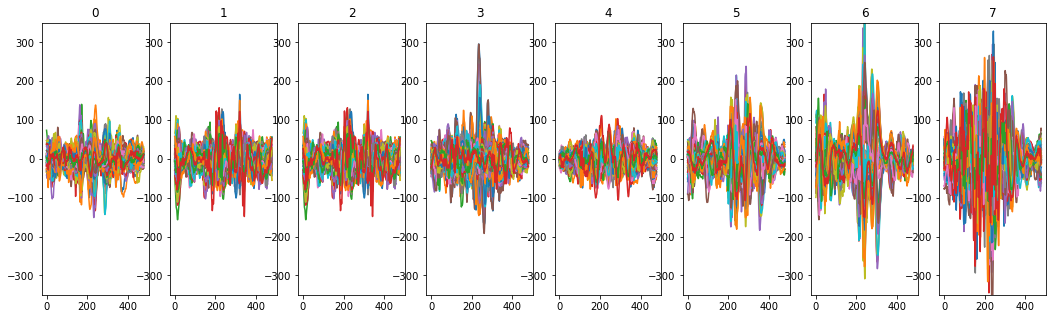

============= label =  0  ===========


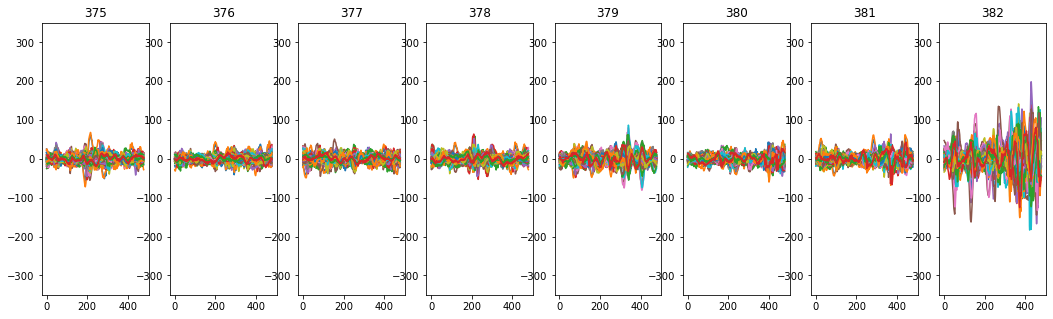

In [7]:
##VIS CODE
y = online_data['emg_windows']
x = np.arange(0, subwindow_len)

num_samples = online_data['key_label'].shape[0]
# plot early data: 
def plot_emg(range_start, range_end, label = 1):
    num_plot = 8
    print('============= label = ', str(label), ' ===========')
    fig, axes = plt.subplots(1,num_plot)
    fig.set_size_inches(18 , 5, forward=True)
    subplot_tracker = 0
    for i in range(range_start, range_end): 
        if subplot_tracker > num_plot-1: 
            plt.show()
            break
        if label != online_data['key_label'][i]:
            continue
        for j in range(0, 64):
            axes[ subplot_tracker ].plot(x, y[i, :, j])
        axes[ subplot_tracker ].set_ylim(-350,350)
        axes[ subplot_tracker ].set_title(str(i))        
        subplot_tracker = subplot_tracker + 1
    plt.show()
plot_emg(0,num_samples,1)
plot_emg(0,num_samples,0)


## Testing on Online Data
1. load online data, see how the label distribution looks, how the signals look before and after pruning the deleted characters.

In [8]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
#config['model']['data_scale'] = 1.0e6

In [9]:
# take combined-data
# shuffle: bc want high performance on both offline and online data, so validation on online and offline both matter? 
# alternative: train on both, val on online? this may be best for online performance...? 

# this replaces half of the offline train data with online, and tests/validates on online data.
# assumes 60 samples per finger

train_data_online, val_test_data = train_test_split(online_data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.70,
                                            stratify=online_data['key_label'],
                                            random_state=config['random_seed'])


train_data = np.concatenate((offline_data, train_data_online))
print(train_data.shape)
# relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])

train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=True)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.y = train_data['key_label']
train_dataset.start_idxs = train_data['start_idxs']
train_dataset.num_chans = train_dataset.X.shape[-1]

train_dataset.print_counts()
target = 1500
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, var_factor=4, time_shift=True, add_noise=False, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

(3235,)
0.0, NULL: 2274
1.0, : 961
Already have 2274!
0.0, NULL: 2274
1.0, : 1500


In [10]:
print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
#
#
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal
3774 94 95


In [16]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
offline_experiment_dir = f"/home/john/emg_decoder/models/"+offline_model_dir
accelerator = 'cuda'
devices = [0]

# model.load_state_dict(torch.load(PATH), weights_only=True)
# torch.save()


system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
        run=False
        )
# should i load it as a ckpt or as a pytorch model like I'm doing now? 
# system = KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=09-val_loss=0.05.ckpt")

system.load_state_dict(torch.load(f"{offline_experiment_dir}/models/"+offline_model_dir+".pt"))
trainer.fit(system, ckpt_path=None)


Seed set to 4995


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | loss  | CrossEntropyLoss   | 0     
1 | acc   | MulticlassAccuracy | 0     
2 | model | KeyClassifier      | 145 K 
---------------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.583     Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

In [17]:
expt = Experiment(system_type, experiment_dir, version=0)
LIST_of_checkpoints = expt.list_checkpoints()[1:]
print(LIST_of_checkpoints)

Versions: ['0', '1'] available, loading version 0...
['bell-epoch=02-val_loss=0.82.ckpt', 'bell-epoch=01-val_loss=0.75.ckpt', 'last.ckpt', 'bell-epoch=08-val_loss=0.79.ckpt', 'bell-epoch=00-val_loss=0.81.ckpt']


bell-epoch=02-val_loss=0.82.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9894737005233765
        test_loss           0.04531710594892502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

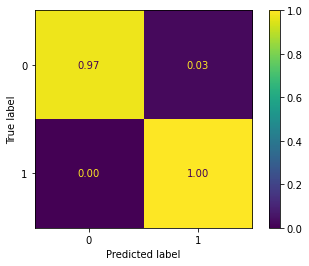

bell-epoch=01-val_loss=0.75.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9578948020935059
        test_loss           0.1087556704878807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

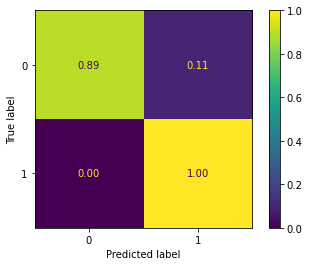

last.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9894737005233765
        test_loss           0.0263788104057312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

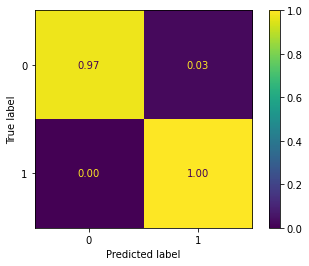

bell-epoch=08-val_loss=0.79.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.010813971981406212
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

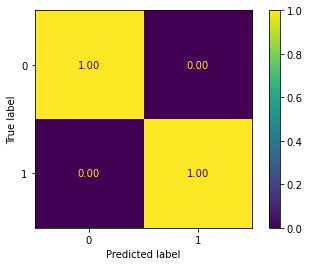

bell-epoch=00-val_loss=0.81.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9684211015701294
        test_loss           0.09341360628604889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

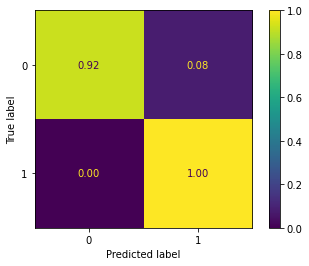

/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.010813971981406212
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

best ckpt:  [{'test_loss': 0.010813971981406212, 'test_acc': 1.0}]


In [18]:
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "last.ckpt")
# trainer.test(system)
# out = trainer.predict(system)

best_ckpt = ''
best_acc = 0
for ckpt in LIST_of_checkpoints: 
    print(ckpt)
    system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + ckpt, strict=False)
    ret = trainer.test(system)
    if ret[0]['test_acc'] > best_acc:
        best_ckpt = ckpt
        best_acc = ret[0]['test_acc']
    out = trainer.predict(system)
    ys = np.concatenate([a[1] for a in out])
    preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
    disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')
    plt.show()
system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
test_perf = trainer.test(system)
out = trainer.predict(system)
print('best ckpt: ', test_perf)

In [19]:
# # if i want to override the choice
# best_ckpt = "bell-epoch=05-val_loss=0.28.ckpt"
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
# test_perf = trainer.test(system)
# out = trainer.predict(system)
# disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')

In [20]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])

(95, 2) (95,)


In [21]:
##Plot errors
from scipy.special import softmax
x = np.arange(0, subwindow_len)
y = test_data['emg_windows']
for i in range(len(ys)):
    if(ys[i] != preds[i]):
        plt.figure(i)

        temp = "truth: " + str(ys[i]) + " predicted: " + str(preds[i]) + str(softmax(Xs[i]))
        plt.title(temp)

        for j in range(1, 64):
            plt.plot(x, y[i, :, j])
        plt.show()

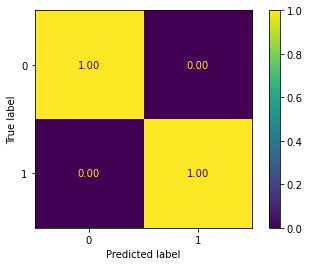

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')


In [23]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")
print(f"experiment_directory: {experiment_dir}")
print(f"checkpoint_name: {config['name']}.pt")

experiment_directory: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal
checkpoint_name: derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_recal.pt
